In [1]:
import os
import tqdm

%matplotlib widget
import matplotlib
import matplotlib.pyplot
import seaborn

import datetime
import pytz

import pandas
import numpy
import pickle

import scipy
import scipy.stats

import accels_utils.frame_accels as FA

In [2]:
# Processing initialization
DATA_RECALCULATION = False
COMB = '3.2.10'
root_path   = '/Users/matthieu/Documents/proto3/active_sensing/'
data_path = root_path + 'AS_data/'

F_ACQ = 1600


ACC_NUMBER  = 10
AXIS        = ['X', 'Y', 'Z']

proc_path           = root_path + 'processed_data/'

if not(os.path.isdir(proc_path)):
    os.makedirs(proc_path, exist_ok=True)

In [3]:
# Files list for the different configs
N_FILES_EXPECTED = 40*3

# Naked comb config
files_list = sorted([x for x in os.listdir(data_path) if x.startswith('acc') and x.endswith('.txt')])
print('Discovered {} files for waxed comb experiment (expected {})'.format(len(files_list), N_FILES_EXPECTED))

Discovered 120 files for waxed comb experiment (expected 120)


In [4]:
# Parameters
ACT_ACC_PAIRING_TOP         = {0:1, 1:2, 2:3, 3:4, 4:6, 5:8, 6:9, 7:9}
ACT_ACC_PAIRING_NEIGHBOR    = {0:2, 1:3, 2:4, 3:3, 4:8, 5:6, 6:8, 7:1}

MAPPING_ACT = {0:[1,0], 1:[1,1], 2:[1,2], 3:[1,3], 4:[0,3], 5:[0,2], 6:[0,1], 7:[0,0]}

In [5]:
# first naive plot
water_configs = {0:'Naked', 1:'1/4', 2:'2/4', 3:'3/4', 4:'4/4'}
exp_configs = {
    'file':[x for x in files_list],
    'frequency':[int(x.split('.')[0].split('_')[-1][1:]) for x in files_list],
    'actuator':[int(x.split('.')[0].split('_')[-2][1:]) for x in files_list],
    'water_config_id':[int(x.split('.')[0].split('_')[-3][1:]) for x in files_list],
    'water_config':[water_configs[int(x.split('.')[0].split('_')[-3][1:])] for x in files_list]
}

exp_configs = pandas.DataFrame.from_dict(exp_configs)

if DATA_RECALCULATION : 
    # Data extraction : taking around 25 minutes
    data = []
    for _, exp in exp_configs.iterrows():
        dp = {'filename':[], 'data':[], 'frequency':[], 'water_config':[], 'actuator':[]}
        try:
            data_file = exp['file']
            with open(data_path + data_file) as accfile:
                dat = accfile.readlines()
            dp['filename']        = data_file
            dp['data']            = FA.extract_data(dat)
            dp['frequency']       = exp['frequency']
            dp['actuator']        = exp['actuator']
            dp['water_config_id'] = exp['water_config_id']
            dp['water_config']    = exp['water_config']
        except : 
            print('There was a problem reading file {}'.format(data_path + data_file))
        data.append(dp)
    data = pandas.DataFrame.from_dict(data)

    with open(proc_path + 'saved_accs_water.json', 'wb') as fp:
        pickle.dump(data, fp)
else :
    with open(proc_path + 'saved_accs_water.json', 'rb') as fp:
        data = pickle.load(fp)

data


,filename,data,frequency,water_config,actuator,water_config_id
0,acc_w0_a0_f400.txt,"{1: {'X': {'val': [0.0, 0.0, 0.0, 0.0, 0.0, 0....",400,Naked,0,0
1,acc_w0_a0_f500.txt,"{1: {'X': {'val': [-9.8221, -9.8395, -9.8269, ...",500,Naked,0,0
2,acc_w0_a0_f600.txt,"{1: {'X': {'val': [-9.7982, -9.8323, -9.8287, ...",600,Naked,0,0
3,acc_w0_a1_f400.txt,"{1: {'X': {'val': [-9.8419, -9.8305, -9.8353, ...",400,Naked,1,0
4,acc_w0_a1_f500.txt,"{1: {'X': {'val': [-9.8048, -9.7886, -9.7844, ...",500,Naked,1,0
...,...,...,...,...,...,...
115,acc_w4_a6_f500.txt,"{1: {'X': {'val': [-9.7958, -9.773, -9.785, -9...",500,4/4,6,4
116,acc_w4_a6_f600.txt,"{1: {'X': {'val': [0.0, 0.0, 0.0, 0.0, 0.0, 0....",600,4/4,6,4
117,acc_w4_a7_f400.txt,"{1: {'X': {'val': [-9.7551, -9.7449, -9.7419, ...",400,4/4,7,4
118,acc_w4_a7_f500.txt,"{1: {'X': {'val': [-9.7569, -9.782, -9.7551, -...",500,4/4,7,4


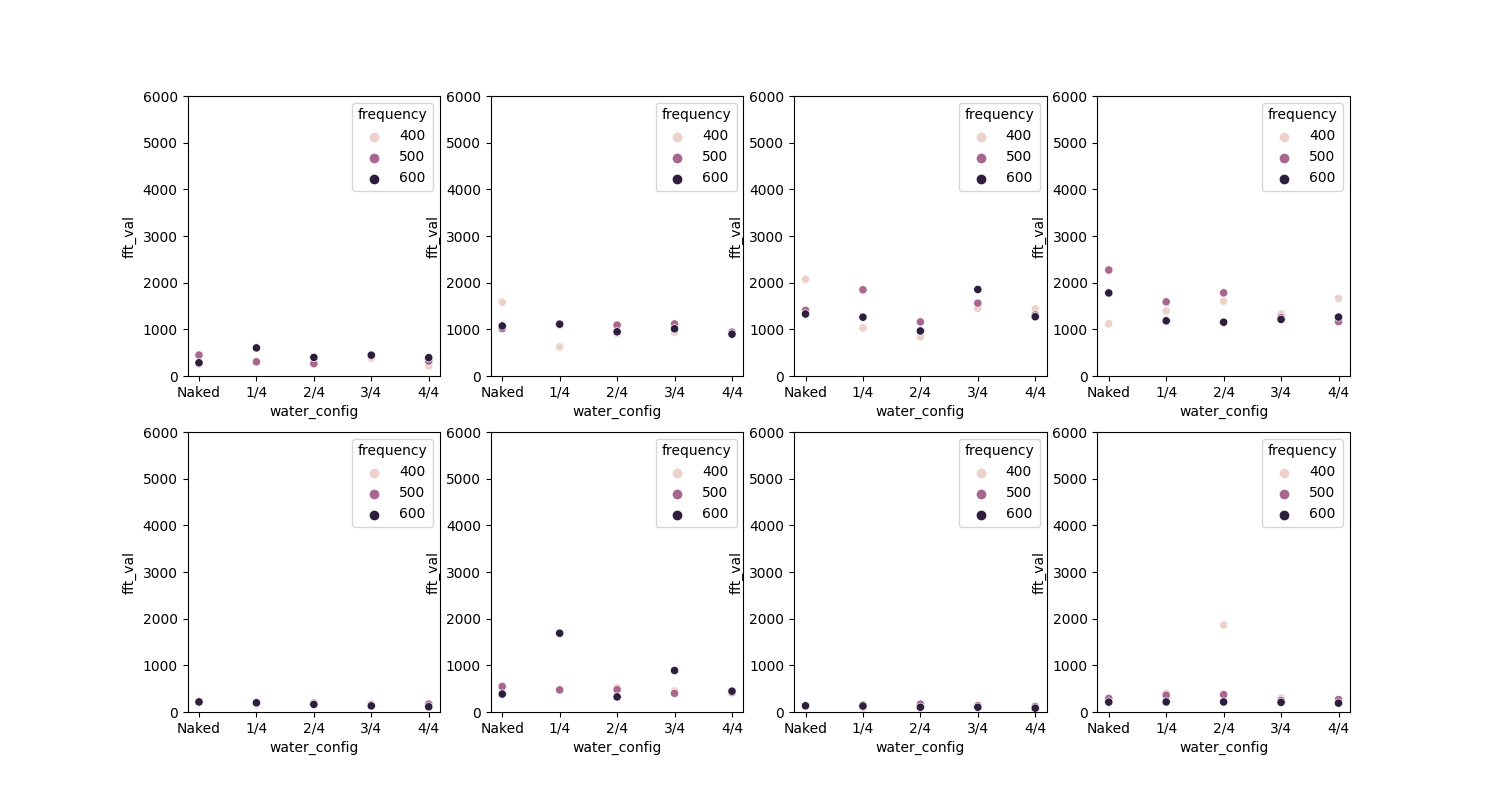

In [26]:
# On top of act
res_df = []

for exp_i, exp in data.iterrows():
    
    interesting_acc = ACT_ACC_PAIRING_TOP[exp['actuator']]
    
    res_dp = {'acc':interesting_acc, 'actuator':exp['actuator'], 'frequency':exp['frequency'], 'water_config_id':exp['water_config_id'], 'water_config':exp['water_config']}

    vals = exp['data'][interesting_acc]['Z']['val']
    sig = numpy.array([vals[i] for i in range(len(vals)) if not(vals[i]==0.0)])
    # sig=vals

    sig_fft = sig[:800]
    sig_fft = numpy.fft.fft(sig_fft-numpy.mean(sig_fft))
    fre_fft = numpy.fft.fftfreq(sig_fft.shape[0], 1/1600)[:int(sig_fft.shape[0]/2)]
    sig_fft = sig_fft[:int(sig_fft.shape[0]/2)]
    TOLERANCE_FREQ = 100
    min_index = numpy.argwhere(fre_fft > res_dp['frequency']-TOLERANCE_FREQ)[0][0]
    max_index = numpy.argwhere(fre_fft < res_dp['frequency']+TOLERANCE_FREQ)[-1][0]
    # print(max_index)
    res_dp['fft_val'] = numpy.sum(numpy.abs(sig_fft[min_index:max_index]))

    res_df.append(res_dp)

res_df = pandas.DataFrame.from_dict(res_df)
res_df

fig, ax = matplotlib.pyplot.subplots(2, 4, figsize=(15,8))
for act in range(8):
    res = res_df[res_df.actuator == act]
    # res = res[res.frequency == 400]
    seaborn.scatterplot(data=res, x="water_config", y="fft_val", hue='frequency', ax=ax[MAPPING_ACT[act][0],MAPPING_ACT[act][1]])
    ax[MAPPING_ACT[act][0],MAPPING_ACT[act][1]].set_ylim([0, 6000])


537.3060428917719 1.0
548.3975448259164 0.9335753443701352
677.462868855683 0.8597057614165331
670.4450281684875 0.850914408452556
449.78211003822696 0.8471917811832859
1-2 RanksumsResult(statistic=0.811502671200689, pvalue=0.4170770595205646)
2-3 RanksumsResult(statistic=-0.027050089040022967, pvalue=0.9784197833524485)
3-4 RanksumsResult(statistic=0.5680518698404823, pvalue=0.5699997477501184)

1-3 RanksumsResult(statistic=0.7303524040806201, pvalue=0.4651748036184682)
2-4 RanksumsResult(statistic=0.45985151368039046, pvalue=0.6456228047372299)

1-4 RanksumsResult(statistic=1.4607048081612402, pvalue=0.14409646897982906)


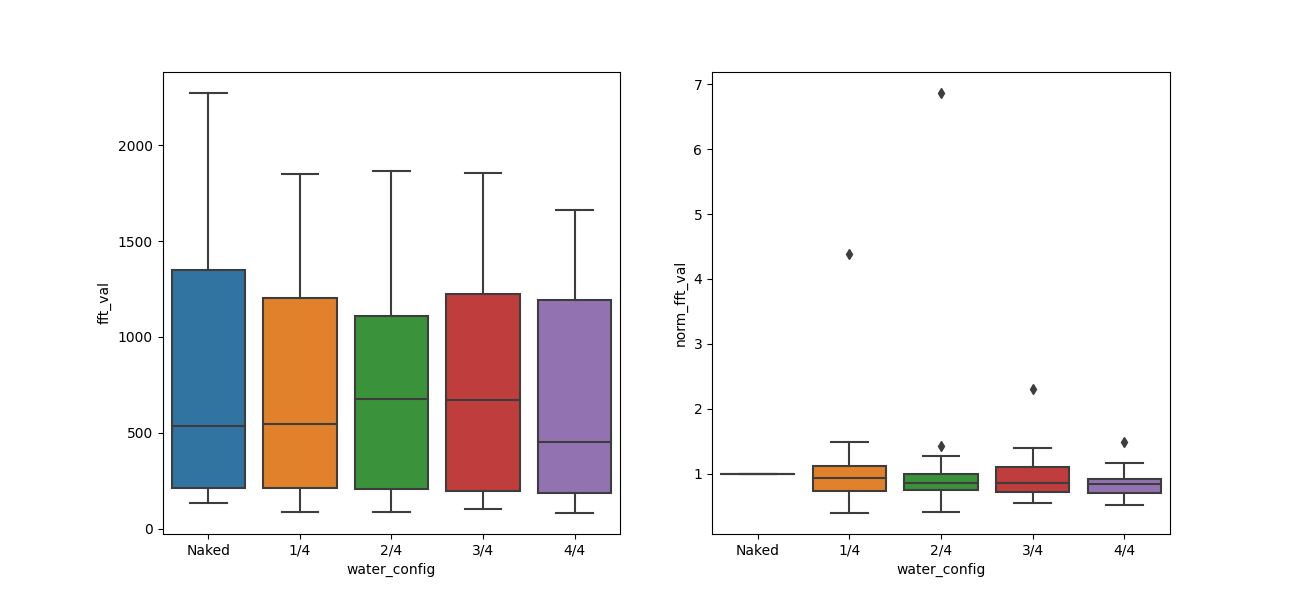

In [27]:
# Average on all acts
res_normalized = res_df.copy()

bad_experiments = [7, 31, 55, 79, 103]
res_normalized = res_normalized.drop(bad_experiments)
res_normalized = res_normalized[res_normalized.actuator != 7]


normalized_fft_vals = []
for exp_id, exp in res_normalized.iterrows():
    if exp.water_config_id == 0:
        normalized_fft_vals.append(1.0)
        continue
    ref_df = res_normalized[res_normalized.actuator == exp.actuator]
    ref_df = ref_df[ref_df.frequency == exp.frequency]
    ref_df = ref_df[ref_df.water_config_id == 0]
    ref = ref_df.fft_val.values[0]
    normalized_fft_vals.append(exp.fft_val/ref)
        
res_normalized['norm_fft_val'] = normalized_fft_vals

print(res_normalized[res_normalized.water_config_id == 0].fft_val.median(), res_normalized[res_normalized.water_config_id == 0].norm_fft_val.median())
print(res_normalized[res_normalized.water_config_id == 1].fft_val.median(), res_normalized[res_normalized.water_config_id == 1].norm_fft_val.median())
print(res_normalized[res_normalized.water_config_id == 2].fft_val.median(), res_normalized[res_normalized.water_config_id == 2].norm_fft_val.median())
print(res_normalized[res_normalized.water_config_id == 3].fft_val.median(), res_normalized[res_normalized.water_config_id == 3].norm_fft_val.median())
print(res_normalized[res_normalized.water_config_id == 4].fft_val.median(), res_normalized[res_normalized.water_config_id == 4].norm_fft_val.median())

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(13, 6))
_ = seaborn.boxplot(data=res_normalized, x="water_config", y="fft_val", ax=ax[0])
_ = seaborn.boxplot(data=res_normalized, x="water_config", y="norm_fft_val", ax=ax[1])

print("1-2", scipy.stats.ranksums(res_normalized[res_normalized.water_config_id==1].norm_fft_val, res_normalized[res_normalized.water_config_id==2].norm_fft_val))
print("2-3", scipy.stats.ranksums(res_normalized[res_normalized.water_config_id==2].norm_fft_val, res_normalized[res_normalized.water_config_id==3].norm_fft_val))
print("3-4", scipy.stats.ranksums(res_normalized[res_normalized.water_config_id==3].norm_fft_val, res_normalized[res_normalized.water_config_id==4].norm_fft_val))

print("")

print("1-3", scipy.stats.ranksums(res_normalized[res_normalized.water_config_id==1].norm_fft_val, res_normalized[res_normalized.water_config_id==3].norm_fft_val))
print("2-4", scipy.stats.ranksums(res_normalized[res_normalized.water_config_id==2].norm_fft_val, res_normalized[res_normalized.water_config_id==4].norm_fft_val))

print("")
print("1-4", scipy.stats.ranksums(res_normalized[res_normalized.water_config_id==1].norm_fft_val, res_normalized[res_normalized.water_config_id==4].norm_fft_val))


/var/folders/gp/4448rp494v37dvsvd0rwbyvw0000gn/T/ipykernel_89514/1002635067.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = matplotlib.pyplot.subplots(8, 5, figsize=(15,8))


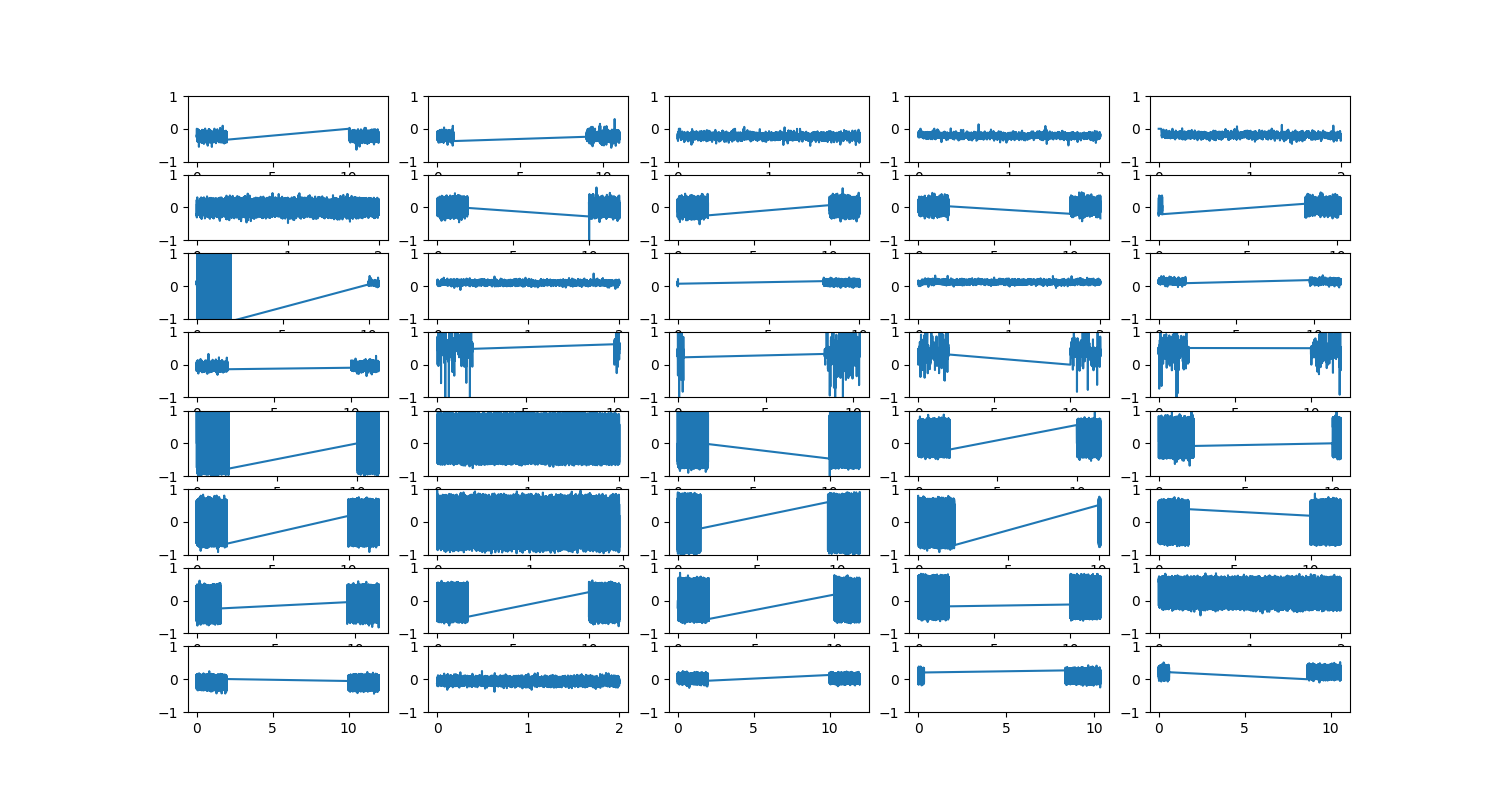

In [28]:
fig, ax = matplotlib.pyplot.subplots(8, 5, figsize=(15,8))

for exp_i, exp in data.iterrows():
    
    if exp['frequency'] != 500:
        continue

    act = exp['actuator']
    acc = ACT_ACC_PAIRING_TOP[act]
    wc_id = exp['water_config_id']

    tims = numpy.array(exp['data'][acc]['Z']['t'])/1000
    tims = tims - numpy.min(tims)
    vals = exp['data'][acc]['Z']['val']

    ax[act, wc_id].plot(tims, vals)
    ax[act, wc_id].set_ylim([-1, 1])

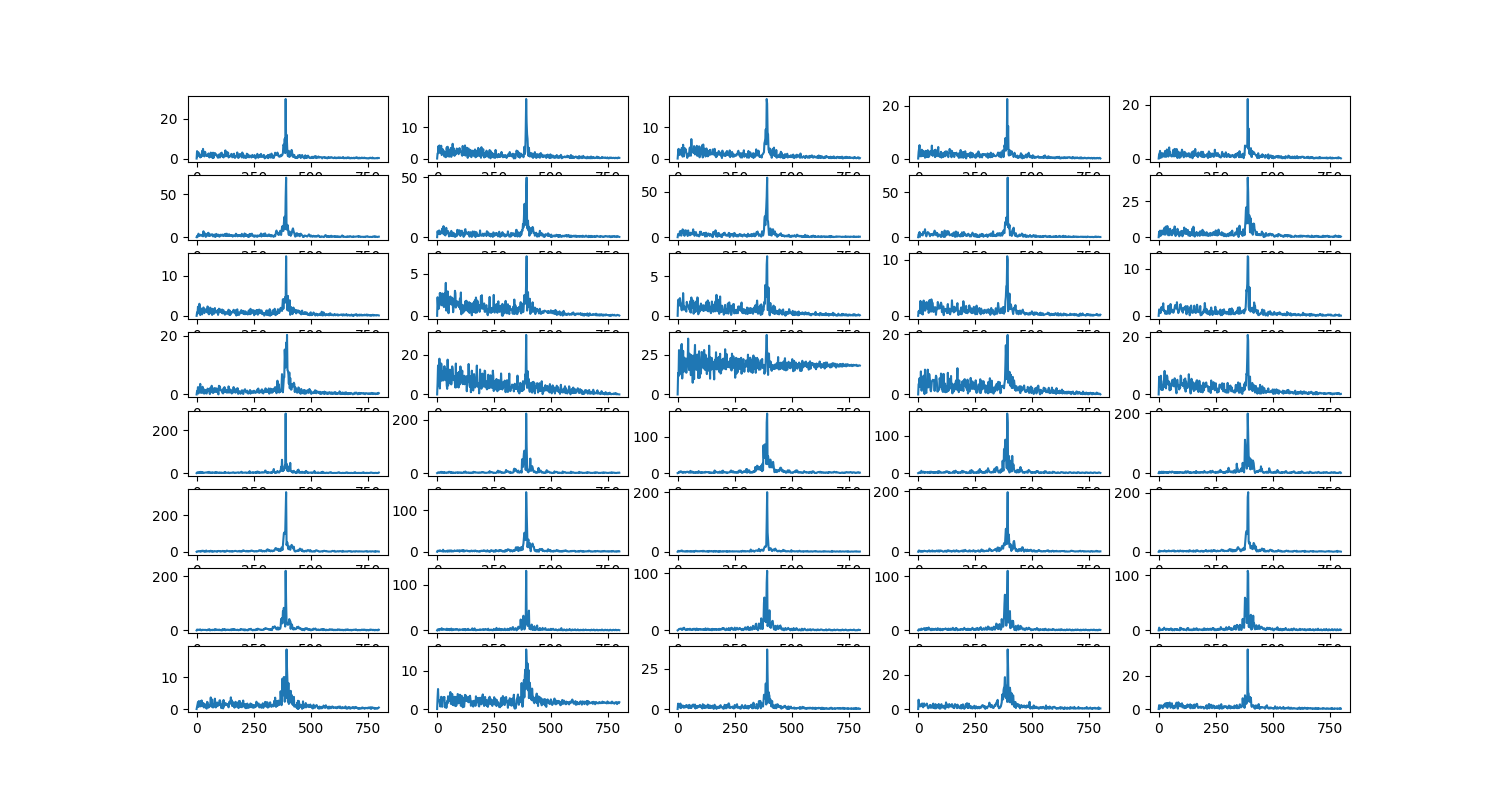

In [20]:
fig, ax = matplotlib.pyplot.subplots(8, 5, figsize=(15,8))

for exp_i, exp in data.iterrows():
    
    if exp['frequency'] != 400:
        continue

    act = exp['actuator']
    acc = ACT_ACC_PAIRING_TOP[act]
    wc_id = exp['water_config_id']

    tims = numpy.array(exp['data'][acc]['Z']['t'])/1000
    tims = tims - numpy.min(tims)
    vals = exp['data'][acc]['Z']['val']
    sig = numpy.array([vals[i] for i in range(len(vals)) if not(vals[i]==0.0)])

    sig_fft = sig[:800]
    sig_fft = numpy.fft.fft(sig_fft-numpy.mean(sig_fft))
    fre_fft = numpy.fft.fftfreq(sig_fft.shape[0], 1/1600)[:int(sig_fft.shape[0]/2)]
    sig_fft = sig_fft[:int(sig_fft.shape[0]/2)]
    TOLERANCE_FREQ = 25
    ax[act, wc_id].plot(fre_fft, numpy.abs(sig_fft))